In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# read in data and turn to tensor

class JointDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

df = pd.read_csv("mldata_log_est.csv")
colnames = df.columns
X = df[colnames[:-1]].to_numpy(dtype=float)
y = df[colnames[-1]].to_numpy(dtype=float)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=3)

sc_x = StandardScaler()
sc_y = StandardScaler()

X_train_std = sc_x.fit_transform(X_train)
y_train_std = sc_y.fit_transform(y_train.reshape(-1,1))

X_val_std_tensor = torch.from_numpy(sc_x.transform(X_val))
y_val_std_tensor = torch.from_numpy(sc_y.transform(y_val.reshape(-1,1)))

X_test_std_tensor = torch.from_numpy(sc_x.transform(X_test))

X_train_std_tensor = torch.from_numpy(X_train_std)
y_train_std_tensor = torch.from_numpy(y_train_std)

train_ds = JointDataset(X_train_std_tensor, y_train_std_tensor)

batch_size=3 # can do 3, 9697, 
train_dl = DataLoader(dataset=train_ds, batch_size=3, shuffle=True)

In [3]:
# Just checking if my GPU has CUDA capability. It does not :/

torch.cuda.is_available()

False

In [4]:
# Making the model

class zGuess_dNN(nn.Module):
    def __init__(self):
        super().__init__()
        # got idea from https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md
        self.layers = nn.Sequential(
            nn.Linear(7,6),
            #nn.Sigmoid(),
            nn.Linear(6,12),
            #nn.Tanh(),
            nn.Linear(12,36),
            #nn.Dropout(p=0.5),
            nn.Linear(36,6),
            nn.Linear(6,1)
        )
    def forward(self, x):
        return self.layers(x)
    
model = zGuess_dNN()
loss_fn = nn.MSELoss(reduction='mean')
loss_fn2= nn.MSELoss(reduction='mean')
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
# Training

num_epochs = 1000

mse_train_arr = []
mse_val_arr = []
epoch_arr = []
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch.float())
        loss = loss_fn(pred, y_batch.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        mse_train_arr.append(loss.cpu().detach().numpy())
        epoch_arr.append(epoch)
        
        pred2 = model(X_val_std_tensor.float())
        loss2 = loss_fn2(pred2, y_val_std_tensor.float())
        mse_val_arr.append(loss2.cpu().detach().numpy())

C:\Users\samir\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


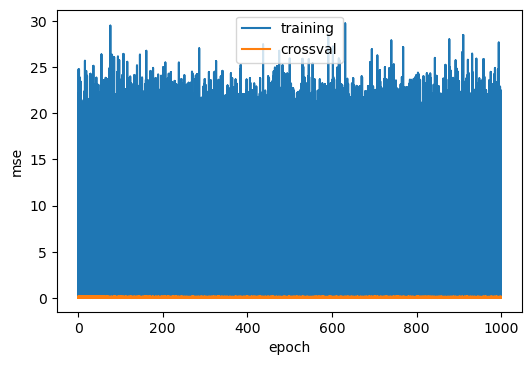

In [6]:
fig, ax = plt.subplots(1,1,dpi=100)
ax.plot(epoch_arr, mse_train_arr, label="training")
ax.plot(epoch_arr, mse_val_arr,   label="crossval")
ax.set_xlabel("epoch")
ax.set_ylabel("mse")
ax.legend()

In [7]:
y_pred_tensor = model(X_test_std_tensor.float())
y_pred = y_pred_tensor.cpu().detach().numpy()
print(mean_squared_error( sc_y.inverse_transform(y_pred), y_test))
print(r2_score( sc_y.inverse_transform(y_pred), y_test))



0.9124168856471814
-6.053725806348532
